# 文書生成AIのファインチューニング
本Notebookでは、RLHFによりファインチューニングしたモデルを評価するコードを記載します。

## 評価

### (1) ライブラリのインストール

利用するライブラリをインストールします。

In [1]:
%pip install pyarrow==12.0.1
%pip install transformers==4.35.2
%pip install trl[peft]==0.7.10
%pip install wandb==0.16.2
%pip install sentencepiece==0.1.99
%pip install accelerate==0.26.1
%pip install bitsandbytes==0.42.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.9/38.9 MB 51.1 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 12.0.1 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.5/123.5 kB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 76.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 96.0 MB/s eta 0:00:00
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transf

### (2) ライブラリのインポート

In [2]:
import torch
from tqdm import tqdm
import pandas as pd
import matplotlib.pyplot as plt

tqdm.pandas()

from transformers import (pipeline, AutoTokenizer,
                          AutoModelForSequenceClassification)
from transformers import AutoModelForCausalLM
from datasets import load_dataset
from peft import LoraConfig
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:441: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(
/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


### (3) モデル名とデータセット名の定義

In [3]:
rm_name = 'Mizuiro-sakura/luke-japanese-base-marcja'
model1_name = 'line-corporation/japanese-large-lm-1.7b'
model2_name = 'taku-yoshioka/rlhf-line-marcja'
dataset_name, subset_name = 'shunk031/JGLUE', 'MARC-ja'

### (4) ファインチューニング済みモデルの読み込み
比較のために元のモデルとファインチューニングしたモデルを読み込みます。

In [4]:
pipe1 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model1_name),
                 tokenizer=AutoTokenizer.from_pretrained(model1_name)
                 )
pipe2 = pipeline('text-generation',
                 model=AutoModelForCausalLM.from_pretrained(model2_name),
                 tokenizer=AutoTokenizer.from_pretrained(model2_name)
                 )

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/2.01k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/utils/generic.py:309: FutureWarning: `torch.utils._pytree._register_pytree_node` is deprecated. Please use `torch.utils._pytree.register_pytree_node` instead.
  _torch_pytree._register_pytree_node(


model.safetensors:   0%|          | 0.00/3.51G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/360 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
/usr/local/lib/python3.10/dist-packages/transformers/convert_slow_tokenizer.py:473: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


adapter_config.json:   0%|          | 0.00/577 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/14.2M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/1.21M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/3.73M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/397 [00:00<?, ?B/s]

In [5]:
texts = ["今日の天気は", "買い物に", "それに加えて"]
for text in texts:
    print(pipe1(text, do_sample=False, pad_token_id=pipe1.tokenizer.pad_token_id))
    print(pipe2(text, do_sample=False, pad_token_id=pipe2.tokenizer.pad_token_id))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': '今日の天気は曇り。 気温は20度。 風は南から。 波'}]
[{'generated_text': '今日の天気は最高でした。 最高の景色を見ながら、 最高のランチを いただきました。 食後は'}]
[{'generated_text': '買い物に出かけて、 帰りに、 スーパーで、 買い物をして、 家に帰ったら、 '}]
[{'generated_text': '買い物に大活躍です。 40代 50代 60代と幅広い'}]
[{'generated_text': 'それに加えて、 1000円カットの店も 1000円カット'}]
[{'generated_text': 'それに加えて、とても使いやすいです。 100均のアイテムとは思えないクオリティです。 1'}]


### (5) 報酬モデルの読み込み

ファインチューニングに使用したものと同じ報酬モデルを読み込みます。

In [6]:
device = 0
sentiment_pipe = pipeline("sentiment-analysis", model=rm_name, device=device)

config.json:   0%|          | 0.00/937 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.12G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.88k [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/842k [00:00<?, ?B/s]

entity_vocab.json:   0%|          | 0.00/21.7M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/40.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/595 [00:00<?, ?B/s]

### (6) 推論

推論の対象となるデータセットをロードします。

In [7]:
def build_dataset(model_name, dataset_name, subset_name=None, split="train",
                  input_min_text_length=2, input_max_text_length=8):
    # トーカナイザをロード
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    tokenizer.pad_token = tokenizer.eos_token

    # データセットをロード、長さが200以上のサンプルを残す
    ds = load_dataset(dataset_name, split=split, name=subset_name,
                      trust_remote_code=True)
    ds = ds.rename_columns({"sentence": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    # 各サンプルの長さをランダムに選ぶ
    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    # 入力サンプルに対して長さをランダムに選び、トークン列に変換
    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [8]:
# データセットを取得し、RLHFの対象となるモデルのトーカナイザでトークン列に変換
dataset = build_dataset(model1_name, dataset_name, subset_name=subset_name,
                        split="validation")

/root/.cache/huggingface/modules/datasets_modules/datasets/shunk031--JGLUE/bef660b0971cf102c95d2554bd2552ce5fb1cf8e9223cc6f8001c70be571c18c/JGLUE.py:464: UserWarning: can't import `mojimoji`, failing back to method that do nothing. We recommend running `pip install mojimoji` to reproduce the original preprocessing.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Filter:   0%|          | 0/5654 [00:00<?, ? examples/s]

Map:   0%|          | 0/2104 [00:00<?, ? examples/s]

In [9]:
dataset.to_pandas().head()

,review,label,review_id,input_ids,query
0,特典ディスクが付いているので買いだと思います。僕の持ってるDVDは一枚組ですけど特典映像で...,0,R24S7IQZ4ICJMG,"[263, 2697]",特典
1,素晴らしいカードです。エジプト、ユダヤ、カバラ、キリスト教……といった文化の融合から生まれて...,0,RRY8KZHSDWMYL,"[263, 1597]",素晴らしい
2,最早、アークティック・モンキーズには彼らが持っていた強みがなくなった。今、1stと同じような...,1,R1CL1S4XFIFYQ3,"[263, 49781, 264, 15420, 11738, 283, 32446]",最早、アークティック・モンキー
3,曲良し、バンドのブルーヴ良好、ボーカルハーモニー最高。フィドルやオルガン、ホーン、ウーリッツ...,0,R1P72JRXKJ0KM,"[263, 924, 11475, 264, 1848, 267]",曲良し、バンドの
4,アクションが多く、一回観ただけでは動きを完全に把握しきれない。ストイックだけど迫力は十分で見...,0,R2ZAYB8PUXG2HA,"[263, 4569, 1896, 264, 5509, 22816, 5557]",アクションが多く、一回観ただけでは


In [10]:
texts = ["特典ディスク", "素晴らしいカード", "アクションが多く"]
for text in texts:
    print(pipe1(text, do_sample=False, pad_token_id=pipe1.tokenizer.pad_token_id))
    print(pipe2(text, do_sample=False, pad_token_id=pipe2.tokenizer.pad_token_id))

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


[{'generated_text': '特典ディスク付 / 2CD / 2枚組 / デジパック仕様'}]
[{'generated_text': '特典ディスクも見応えたっぷりで、 何度見ても飽きない。 2017年1'}]
[{'generated_text': '素晴らしいカードです。 2019年12月21日 11'}]
[{'generated_text': '素晴らしいカードです。 2018年は、 私にとって、 最高の年になりそうです'}]
[{'generated_text': 'アクションが多く、 アクションが派手で、 アクションが派手で、 アクションが派手'}]
[{'generated_text': 'アクションが多く、とても楽しめました。 アクションも派手で、見ていて飽きません。 アクションも'}]


推論結果を評価するための関数を定義します。

In [11]:
def evaluate(dataset, pipe1, pipe2, sentiment_pipe):
    reward1 = []
    reward2 = []
    text1 = []
    text2 = []

    for i, text in enumerate(tqdm(dataset)):
        out1 = pipe1(text["query"], do_sample=False,
                    pad_token_id=pipe1.tokenizer.pad_token_id)
        out2 = pipe2(text["query"], do_sample=False,
                    pad_token_id=pipe2.tokenizer.pad_token_id)
        t1 = out1[0]["generated_text"]
        t2 = out2[0]["generated_text"]
        r1 = sentiment_pipe(t1)[0]["score"]
        r2 = sentiment_pipe(t2)[0]["score"]
        reward1.append(r1)
        reward2.append(r2)
        text1.append(t1)
        text2.append(t2)
        if i > 100:
            break

    df = pd.DataFrame({"reward1": reward1, "reward2": reward2,
                       "text1": text1, "text2": text2})
    return df


評価結果をデータフレームに格納します。

In [12]:
df = evaluate(dataset, pipe1, pipe2, sentiment_pipe)

  0%|          | 5/2104 [00:24<2:37:46,  4.51s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(
  5%|▍         | 101/2104 [07:34<2:30:04,  4.50s/it]


### (7) 結果の確認

ファインチューニング前後のモデルによる生成文と、それらに対する報酬を出力します。

In [13]:
df.head()

,reward1,reward2,text1,text2
0,0.955078,0.998380,特典 : 1. 1000円OFFクーポン 2. 1,特典も盛りだくさんで、とても満足しました。 2019年12月2
1,0.995323,0.998183,素晴らしいです。 100% の 100% の 1,素晴らしいです。 100%満足のお店です。 2016年1
2,0.944948,0.998335,最早、アークティック・モンキーズは、 ロックの枠に収まらない、 ジャンル,最早、アークティック・モンキーズ史上最高傑作と言っても過言ではない。 2017年、最高の
3,0.997327,0.998435,曲良し、バンドの一体感良し、 MCも面白いし、 何より、 ステージ,曲良し、バンドの一体感も良し、 何より、 歌詞が素晴らしい。 歌詞
4,0.998365,0.998476,アクションが多く、一回観ただけでは理解しきれない部分も多い。 なので、何度も観たくなる。,アクションが多く、一回観ただけでは飽きません。 アクションシーンも、迫力があり、見応えがあります


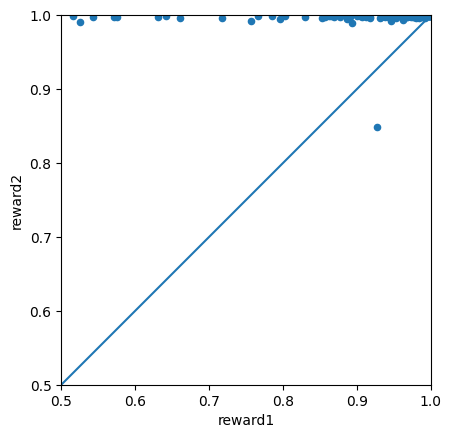

In [14]:
df.plot.scatter("reward1", "reward2")
plt.plot([0, 1], [0, 1])
plt.xlim([0.5, 1])
plt.ylim([0.5, 1])
plt.gca().set_aspect("equal")

In [15]:
df[["text1", "text2"]]

,text1,text2
0,特典 : 1. 1000円OFFクーポン 2. 1,特典も盛りだくさんで、とても満足しました。 2019年12月2
1,素晴らしいです。 100% の 100% の 1,素晴らしいです。 100%満足のお店です。 2016年1
2,最早、アークティック・モンキーズは、 ロックの枠に収まらない、 ジャンル,最早、アークティック・モンキーズ史上最高傑作と言っても過言ではない。 2017年、最高の
3,曲良し、バンドの一体感良し、 MCも面白いし、 何より、 ステージ,曲良し、バンドの一体感も良し、 何より、 歌詞が素晴らしい。 歌詞
4,アクションが多く、一回観ただけでは理解しきれない部分も多い。 なので、何度も観たくなる。,アクションが多く、一回観ただけでは飽きません。 アクションシーンも、迫力があり、見応えがあります
...,...,...
97,体の関係は、 100% ありません。 2018年0,体の関係もスムーズで、とても居心地の良い関係です。 お互いに、相手のことをとても大切に
98,ずーっと、ずっと、 ずーっと、 ずーっと、 ずーっと、 ずーっと、 ずーっと、,ずーっとずっと大好きな曲です。 この曲を聴くと、いつも元気をもらえます。 この曲を聴く
99,U2000 1000 XXXX 1000 10,U2の名曲が見事に再現されています。 アルバムのラストを飾る曲で、アルバムのラスト
100,久しぶりに見る。映画館で観るのは久しぶり。 2019年12月11,久しぶりに見る。映画館で見るの楽しい。 2019年12月17日


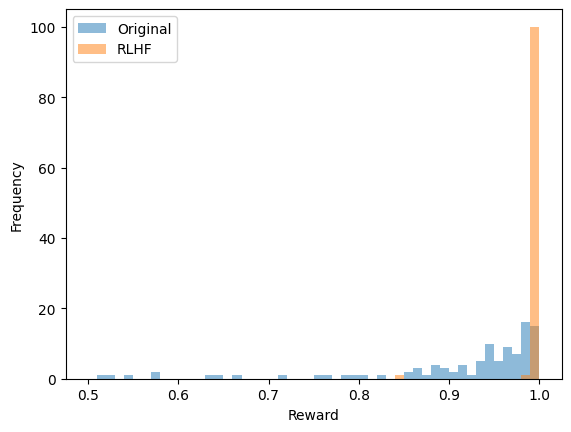

In [16]:
df["reward1"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="Original")
df["reward2"].hist(range=(0.5, 1), bins=50, alpha=0.5, label="RLHF")
plt.gca().grid(False)
plt.xlabel("Reward")
plt.ylabel("Frequency")
plt.legend()

In [17]:
df[df["reward1"] < 0.9][["text1", "text2"]]

,text1,text2
9,否定的な意見を書けば、 批判的な意見も書きたくなる。 批判的な意見は、,否定的な意見を書けば、とてもわかりやすく、とても参考になります。 この本は、本当におすすめで...
10,分析的な感想が多く、 分析的な感想は、 分析的な感想で、 分析,分析的な感想が多く、とても参考になりました。 2017年12月22
11,先祖がえり 2018-09-25 19:0,先祖が大切にしてきたものを受け継いでいく、とても素晴らしいことだと思います。 2018年1
12,オペラ座の怪人 2018-09-25 19,オペラ座の怪人の中でも大好きな曲です。 この曲を聴くと、いつも元気をもらえます
13,ちょっとちょっと...あまりにもなレビューなので、ちょっと一言。 1000円もするんだから,ちょっとちょっと...あまりにもなレビューなので、とても嬉しかったです。 本当にありがとうご...
19,とんでもない。 1000円札を1枚、100円玉を1,とんでもないです! めちゃくちゃ嬉しいです! 本当にありがとうございます! 1番好きな...
24,価格.comの最安値で、1000円ちょっと。 1000円,価格.comの満足度も非常に高い製品です。 2018年12月時点で
27,DVDからBlueRayにダビングする方法<0x0A>DVDからBlueRayにダビングする...,DVDからBlueRayまで、幅広く対応しています。 100%の互換性 10
30,このCDは確かに、 100%の完成度ではない。 100%の完成度,このCDは確かに素晴らしい。 2017年11月21日 11
32,カラスの行水 2018-08-29 19:,カラスの鳴き声も心地よく、 心が洗われるような気持ちになりました。 2017
